In [3]:
! pip install -q 'lalsuite==7.11' 'PyCBC==2.0.5'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 58.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/

### Significance of Virgo SNR peak of GW170814 ###



#### Preconditioning Gravitational Strain Data ####


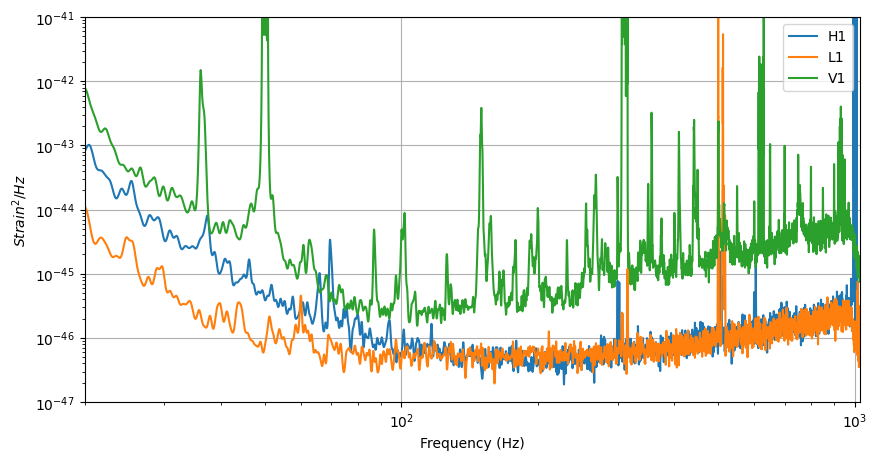

In [7]:
import matplotlib.pyplot as plt

from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.catalog import Merger

merger=Merger('GW170814')
ifos=['H1','L1','V1']
data={}
psd={}

plt.figure(figsize=[10,5])

for ifo in ifos:
  ts=merger.strain(ifo).highpass_fir(15,512)
  data[ifo]=resample_to_delta_t(ts,1./2048).crop(2,2)
  PSD=data[ifo].psd(2)
  PSD=interpolate(PSD,data[ifo].delta_f)
  psd[ifo]=inverse_spectrum_truncation(PSD,int(2*data[ifo].sample_rate),low_frequency_cutoff=15.0)
  plt.plot(psd[ifo].sample_frequencies,psd[ifo],label=ifo)

plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-47, 1e-41)
plt.xlim(20, 1024)
plt.ylabel('$Strain^2 / Hz$')
plt.xlabel('Frequency (Hz)')
plt.grid()
plt.legend()
plt.show()

#### Generate template waveform and calculate SNR time series ####

Simplifying assumptions:<br>
1. Non spinning black holes
2. Equal mass

In [9]:
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter

# Calculate the component mass of each black hole in the detector frame
cmass = (merger.median1d("mass1")+merger.median1d("mass2")) / 2
cmass *= (1 + merger.median1d("redshift"))

hp,_=get_fd_waveform(approximant='IMRPhenomD',
                     mass1=cmass,
                     mass2=cmass,
                     f_lower=20,
                     delta_f=data[ifo].delta_f)
hp.resize(len(psd[ifo]))

# For each observatory use this template to calculate the SNR time series
snr={}
for ifo in ifos:
  snr[ifo]=matched_filter(hp,data[ifo],psd=psd[ifo],low_frequency_cutoff=20)
  snr[ifo]=snr[ifo].crop(4,4)

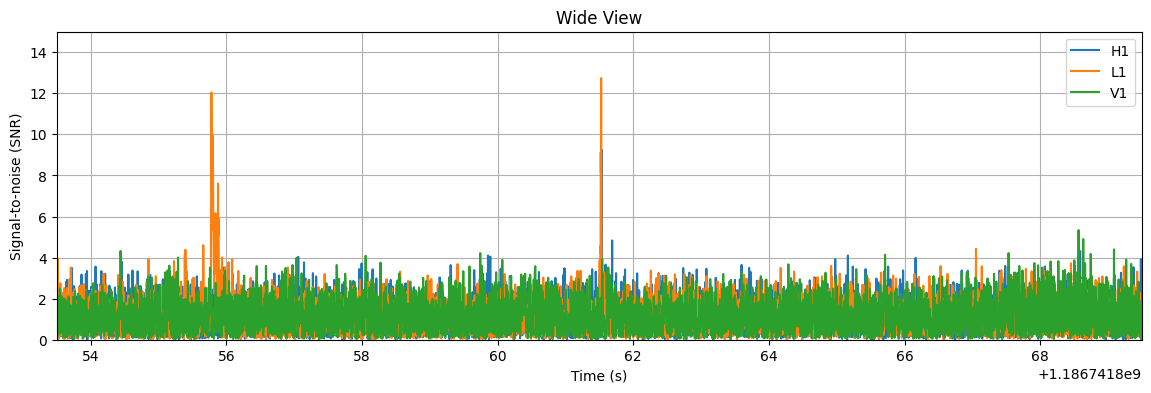

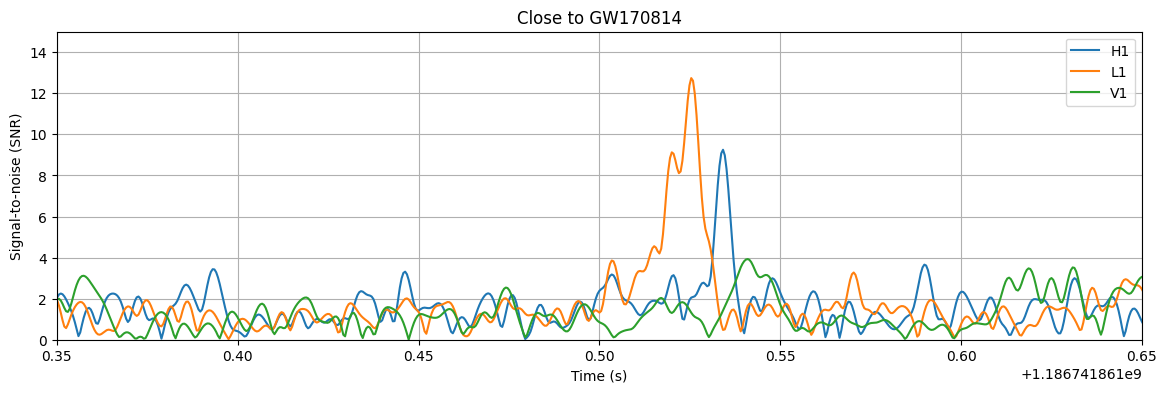

In [11]:
for w, title in [(8, 'Wide View'), (.15, 'Close to GW170814')]:
    plt.figure(figsize=[14, 4])
    for ifo in ifos:
        plt.plot(snr[ifo].sample_times, abs(snr[ifo]), label=ifo)

    plt.legend()
    plt.title(title)
    plt.grid()
    plt.xlim(merger.time - w, merger.time + w)
    plt.ylim(0, 15)
    plt.xlabel('Time (s)')
    plt.ylabel('Signal-to-noise (SNR)')
    plt.show()

#### $\chi^2$-based signal consistency test####


$
\chi^2 = \sum^p_{i=0} (\rho_i - \rho / \rho)^2
$


Statistic will be high when the template does not match well with the data, and near unity when the data either is Gaussian noise, or it contains the expected signal in addition to Gaussian noise.

In [13]:
from pycbc.vetoes import power_chisq

chisq = {}
for ifo in ifos:
    nbins = 26
    chisq[ifo] = power_chisq(hp, data[ifo], nbins, psd[ifo], low_frequency_cutoff=20.0)
    chisq[ifo] = chisq[ifo].crop(5, 4)

    dof = nbins * 2 - 2
    chisq[ifo] /= dof

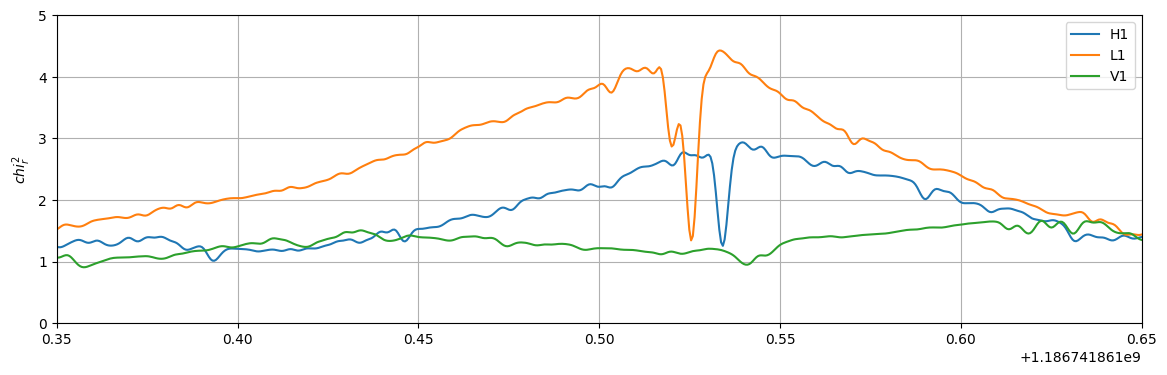

In [15]:
plt.figure(figsize=[14, 4])

for ifo in ifos:
    plt.plot(chisq[ifo].sample_times, chisq[ifo], label=ifo)

plt.legend()
plt.grid()
plt.xlim(merger.time -0.15, merger.time + 0.15)
plt.ylim(0, 5)
plt.ylabel('$chi^2_r$')
plt.show()

Dip in the value at the time of the peak in the SNR in each observatory.

#### Re-weighting our SNR to help down-weight times that don't fit signal/Gaussian noise ####



$\hat{\rho} = \frac{\rho}{ \frac{1}{2}[1 + (\chi^2_r)^3]^{1/6}}$ where $\chi^2 > 1$, otherwise $\rho$


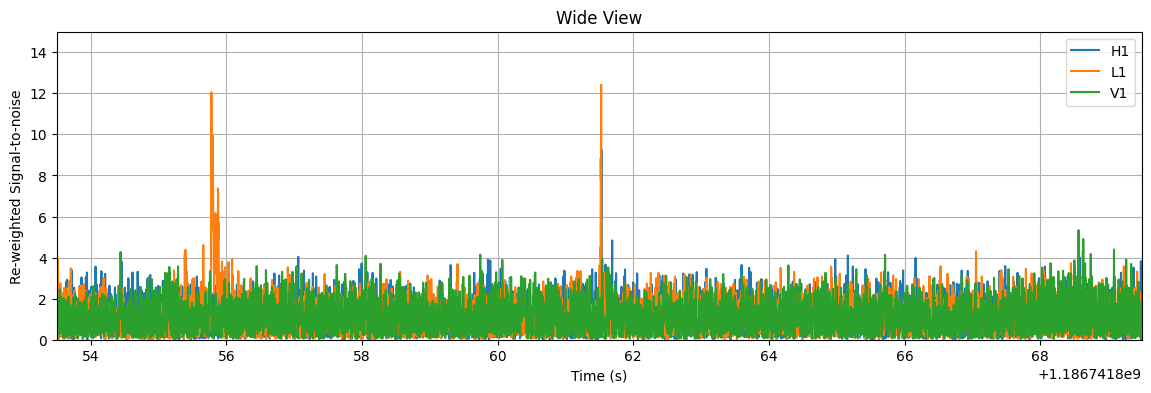

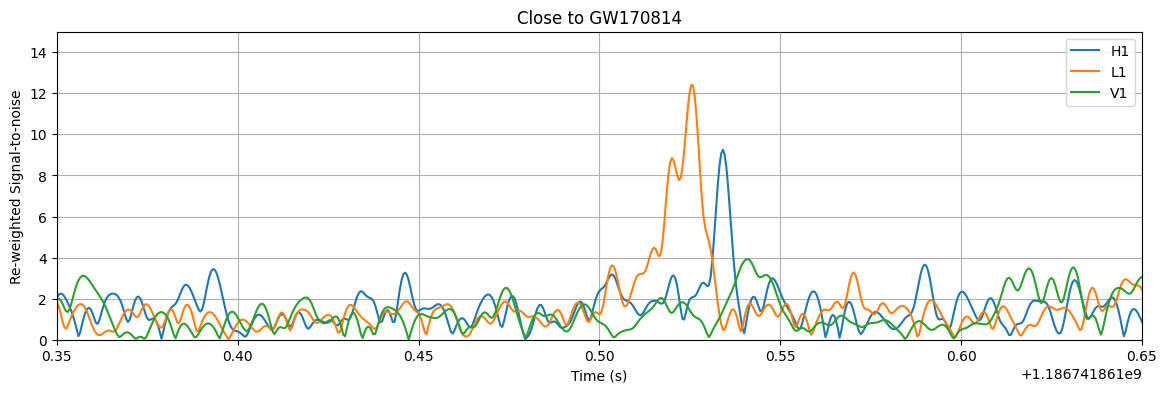

In [16]:
from pycbc.events.ranking import newsnr

nsnr = {ifo:newsnr(abs(snr[ifo]), chisq[ifo]) for ifo in ifos}

for w, title in [(8, 'Wide View'), (.15, 'Close to GW170814')]:
    plt.figure(figsize=[14, 4])
    for ifo in ifos:
        plt.plot(snr[ifo].sample_times, nsnr[ifo], label=ifo)

    plt.legend()
    plt.title(title)
    plt.grid()
    plt.xlim(merger.time - w, merger.time + w)
    plt.ylim(0, 15)
    plt.xlabel('Time (s)')
    plt.ylabel('Re-weighted Signal-to-noise')
    plt.show()

#### Calculating the background and significance ####


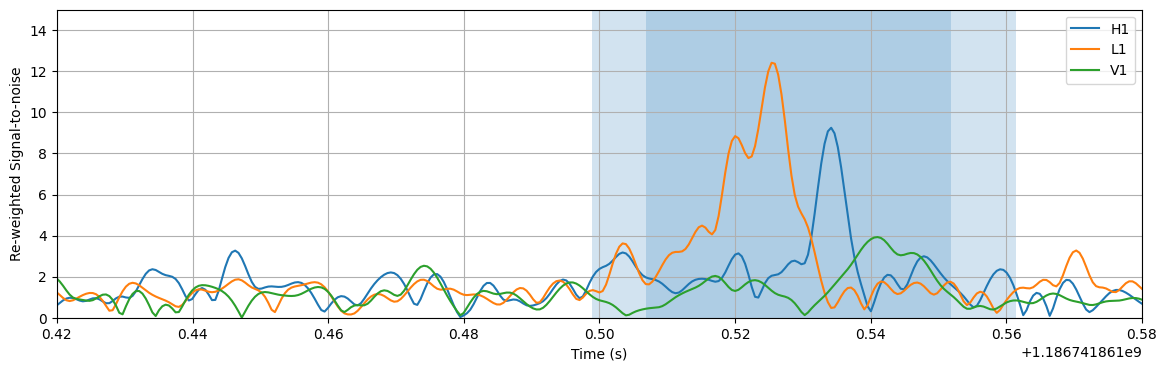

Virgo Peak has a re-weighted SNR value of 3.928067368090752


In [17]:
import numpy
from pycbc.detector import Detector

# Calculate the time of flight between the Virgo detectors and each LIGO observatory
d = Detector("V1")
tof = {}
tof['H1'] = d.light_travel_time_to_detector(Detector("H1"))
tof['L1'] = d.light_travel_time_to_detector(Detector("L1"))

# Record the time of the peak in the LIGO observatories
ptime = {}

plt.figure(figsize=[14, 4])
for ifo in ifos:
    if ifo != 'V1':
        ptime[ifo] = snr[ifo].sample_times[nsnr[ifo].argmax()]
        plt.axvspan(ptime[ifo] - tof[ifo], ptime[ifo] + tof[ifo], alpha=0.2, lw=10)

    plt.plot(snr[ifo].sample_times, nsnr[ifo], label=ifo)

# Span of time that a Virgo peak could in principle happen in from time of flight
# considerations.
start = min(ptime['H1'] - tof['H1'],ptime['L1'] - tof['L1'])
end = max(ptime['L1'] + tof['L1'],ptime['H1'] + tof['H1'])

# convert the times to indices along with how large the region is in number of samples
window_size = int((end - start) * snr['V1'].sample_rate)
sidx = int((start - snr['V1'].start_time) * snr['V1'].sample_rate)
eidx = sidx + window_size

# Calculate the "on-source" peak re-weighted (newsnr) statistic value.
onsource = nsnr['V1'][sidx:eidx].max()

plt.legend()
plt.grid()
plt.xlim(merger.time - .08, merger.time + .08)
plt.ylim(0, 15)
plt.xlabel('Time (s)')
plt.ylabel('Re-weighted Signal-to-noise')
plt.show()

print('Virgo Peak has a re-weighted SNR value of {}'.format(onsource))

In [18]:
# Walk through the data in chunks and calculate the peak statistic value in each.

peaks = []
i = 0
while i + window_size < len(nsnr['V1']):
    p = nsnr['V1'][i:i+window_size].max()
    peaks.append(p)
    i += window_size

    # Skip past the onsource time
    if abs(i - sidx) < window_size:
        i += window_size * 2

peaks = numpy.array(peaks)

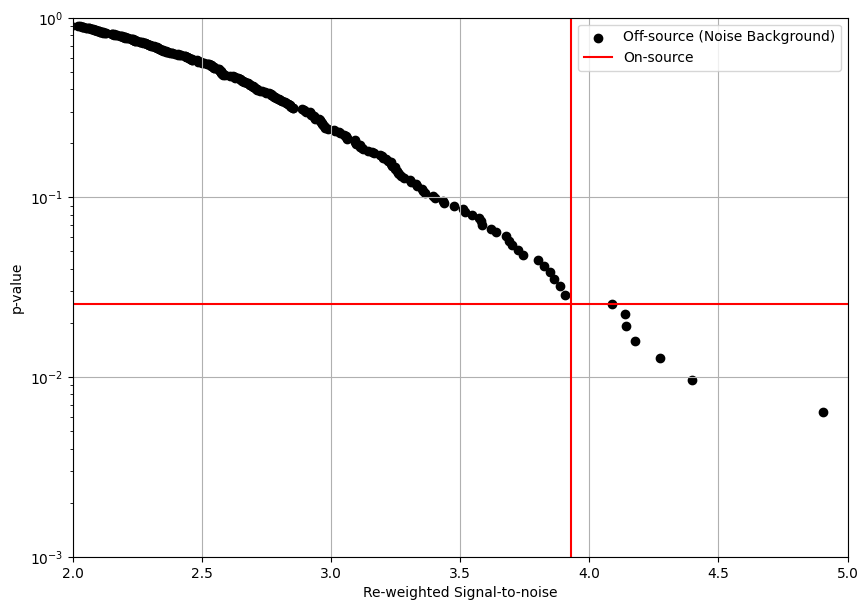

The p-value associated with the GW170814 peak is 0.025559105431309903


In [19]:
pcurve = numpy.arange(1, len(peaks)+1)[::-1] / float(len(peaks))
peaks.sort()

pvalue = (peaks > onsource).sum() / float(len(peaks))

plt.figure(figsize=[10, 7])
plt.scatter(peaks, pcurve, label='Off-source (Noise Background)', color='black')

plt.axvline(onsource, label='On-source', color='red')
plt.axhline(pvalue, color='red')

plt.legend()
plt.yscale('log')
plt.grid()
plt.ylim(1e-3, 1e0)
plt.ylabel('p-value')
plt.xlabel('Re-weighted Signal-to-noise')

plt.xlim(2, 5)
plt.show()

print("The p-value associated with the GW170814 peak is {}".format(pvalue))